In [1]:
import pandas as pd
import re
import matplotlib.pyplot as pt
import seaborn as sns
import numpy as np

# import nltk library untuk tokenizing, lemmatization dan remove stopword
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

[nltk_data] Downloading package wordnet to C:\Users\Bayu
[nltk_data]     Pramana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Bayu Pramana\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load dataset review film berbahasa Inggris

In [2]:
review_data = pd.read_csv("data/dataset_movie_review.csv")
review_data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
review_data.shape

(50000, 2)

C:\Users\Bayu Pramana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

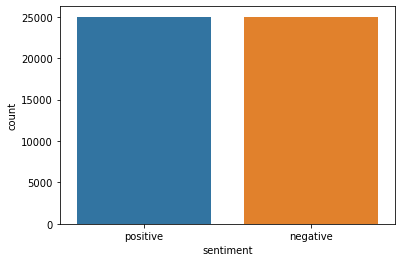

In [4]:
# tampilkan jumlah sentiment dengan grafik
sns.countplot(review_data['sentiment'])

In [5]:
review_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


# Preprocessing Data

In [6]:
# merubah seluruh review menjadi lowercase
review_data['review'] = review_data['review'].str.lower()

In [7]:
# menghapus seluruh digit angka yang ada pada data review
def removeDigit(sentence):
    result = re.sub(r"\d", "", sentence)
    return result

review_data['review'] = review_data['review'].apply(removeDigit)
review_data.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
5,"probably my all-time favorite movie, a story o...",positive
6,i sure would like to see a resurrection of a u...,positive
7,"this show was an amazing, fresh & innovative i...",negative
8,encouraged by the positive comments about this...,negative
9,if you like original gut wrenching laughter yo...,positive


In [8]:
# menghapus seluruh tag HTML yang ada pada data review
def removeTag_html(sentence):
    result = re.sub(r'<.*?>','',sentence)
    return result

review_data['review'] = review_data['review'].apply(removeTag_html)
review_data.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
5,"probably my all-time favorite movie, a story o...",positive
6,i sure would like to see a resurrection of a u...,positive
7,"this show was an amazing, fresh & innovative i...",negative
8,encouraged by the positive comments about this...,negative
9,if you like original gut wrenching laughter yo...,positive


In [9]:
# menghapus seluruh spesial character seperti ,./.()
def removingSpecialChar(sentence):
    result = re.sub(r'[^\w]', ' ', sentence)
    return result

review_data['review'] = review_data['review'].apply(removingSpecialChar)

In [11]:
# menghapus spasi berlebih
def removingMultipleSpacing(sentence):
    result = re.sub('\s+',' ',sentence)
    return result

review_data['review'] = review_data['review'].apply(removingMultipleSpacing)

In [12]:
# simpan data hasil preprocessing
review_data.to_csv('data/preprocessing/clean_dataset.csv', index=False)

In [16]:
# menghapus seluruh stopword yang ada dalam review data menggunakan NLTK
def removingStopwords(sentence):
    stopword_list = stopwords.words('english')
    text_tokens = word_tokenize(sentence)
    filtered_word = [word for word in text_tokens if word not in stopword_list]
    filtered_sentence = (" ").join(filtered_word)
    return filtered_sentence

review_data['review'] = review_data['review'].apply(removingStopwords)

In [17]:
# simpan data hasil penghapusan stopword sebagai data tanpa lemmatization
review_data.to_csv('data/preprocessing/dataset_without_lemmatization.csv', index=False)

In [18]:
# mendapatkan postag tiap kata yang ada di dalam data review
def get_postag_word(word):
    postag = nltk.pos_tag([word])[0][1][0].upper()
    postag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return postag_dict.get(postag, wordnet.NOUN)

In [20]:
# lemmatization data review berdasarkan postag menggunakan WordNetLemmatizer
def lemmatization_word(sentence):
    lemmatizer = WordNetLemmatizer()
    sentence= ' '.join([lemmatizer.lemmatize(word, get_postag_word(word)) for word in sentence.split()])
    return sentence


review_data['review'] = review_data['review'].apply(lemmatization_word)

In [21]:
# simpan data hasil lemmatization
review_data.to_csv('data/preprocessing/dataset_using_lemmatization.csv', index=False)

# Extraksi menggunakan word2vec dengan data lemmatization

In [2]:
# Load dataset hasil lemmatization
review_data = pd.read_csv('data/preprocessing/dataset_using_lemmatization.csv')
review_data.head(10)

,review,sentiment
0,one reviewer mention watch oz episode hooked r...,positive
1,wonderful little production film technique una...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stun fi...,positive
5,probably time favorite movie story selflessnes...,positive
6,sure would like see resurrection date seahunt ...,positive
7,show amaze fresh innovative idea first air fir...,negative
8,encourage positive comment film look forward w...,negative
9,like original gut wrench laughter like movie y...,positive


In [3]:
# ubah review positif = 1 dan negatif = 0
review_data['sentiment'] = review_data['sentiment'].map({'positive':1, 'negative':0})

In [4]:
# pisahkan data menjadi corpus data untuk word2vec dan untuk train test model
corpus_data = review_data.iloc[:45000] # corpus data word2vec sebesar 45000 data
train_test = review_data.iloc[45000:] # train test model sebesar 5000 data

In [5]:
corpus_data.to_csv('data/preprocessing/corpus_lemmatization.csv')

train_test.to_csv('data/preprocessing/data_model_lemmatization.csv')

## Word2vec dengan 100 dimensional vector

In [119]:
%%time


# tokenisasi seluruh kata yang ada dalam corpus yang menggunakan lemmatization
sentence_corpus = [word_tokenize(review) for review in corpus_data.review] 

# bangun model skip-gram dengan vektor size 100 dan window 5
model_100 = Word2Vec(
            sentence_corpus,
            vector_size = 100, # vektor size yang digunakan = 100
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)


#simpan model yang telah bangun
model_100.save("model/lemmatization/word2vec_100.w2v")

Wall time: 39.8 s


In [120]:
# coba model word2vec yang dibangun dengan melihat vector dari kata movie
model_100.wv['movie']

array([-0.15749273,  0.45180756, -0.10939796,  0.37131956,  0.03510791,
       -0.10384069, -0.1046925 ,  0.48323312, -0.37503   , -0.1931874 ,
       -0.10173449, -0.2238978 ,  0.05934507, -0.05434404, -0.04043657,
       -0.16520752,  0.07978155, -0.10826575, -0.24566951, -0.66446126,
        0.5150075 , -0.04622632,  0.08739759,  0.07124893, -0.08877259,
       -0.03109653, -0.4196705 , -0.03160298,  0.00539299,  0.2560579 ,
        0.24828333,  0.0822815 ,  0.23566908, -0.73987734, -0.01224797,
        0.08982772,  0.4041815 , -0.00530707, -0.09679309, -0.28624424,
       -0.01964009, -0.10254408, -0.36908364, -0.11943126, -0.10628622,
       -0.09394993, -0.31710324, -0.08454562, -0.15658006,  0.23581766,
        0.18248108, -0.36479092, -0.27410766,  0.04809016,  0.01019737,
        0.07517741,  0.2995484 ,  0.01625962, -0.2643239 ,  0.15770556,
       -0.15836471, -0.04668534,  0.1363566 ,  0.11172778, -0.16109684,
        0.2231512 ,  0.23120101,  0.2223919 , -0.3050328 ,  0.25

In [5]:
# load model yang berisi word vector dari model yang dibangun
model_100 = Word2Vec.load("model/lemmatization/word2vec_100.w2v").wv

In [6]:
# function untuk memvektorisasi seluruh kalimat review dalam dataset
def sent_vector(sentence, model):
    vecs = [model[word] for word in word_tokenize(sentence) if word in model]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

In [7]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
vecs = [sent_vector(sentence, model_100) for sentence in train_test.review]
features_vect = np.array(vecs)
data_features = pd.DataFrame(features_vect)

# simpan vektor data kedalam csv
data_features.to_csv('data/features/lemmatization_features_100d.csv', index=False)

### Naive Bayes Klasifikasi

In [11]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
acc_score = cross_val_score(gnb_model, data_features, train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
avg_accuracy = round((acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
recall_score = cross_val_score(gnb_model, data_features, train_test.sentiment, cv=cv, scoring = 'recall_macro')
avg_recall = round((recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
precission_score = cross_val_score(gnb_model, data_features, train_test.sentiment, cv=cv, scoring = 'precision_macro')
avg_precission = round((precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
f_score = cross_val_score(gnb_model, data_features, train_test.sentiment, cv=cv, scoring = 'f1_macro')
avg_fscore = round((f_score.mean()),4)

print("Accuracy score = ", avg_accuracy*100)
print("Recall score = ", avg_recall*100)
print("Precission score = ", avg_precission*100)
print("F1-Score = ", avg_fscore*100)

Training Gaussian NB
Accuracy score =  78.9
Recall score =  78.89
Precission score =  78.91
F1-Score =  78.86
Wall time: 410 ms


## Word2Vec dengan 200 dimensional vector

In [144]:
%%time


# bangun model skip-gram dengan vektor size 200 dan window 5
model_200 = Word2Vec(
            sentence_corpus,
            vector_size = 200, # vektor size yang digunakan = 200
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

# simpan model yang telah dibangun
model_200.save("model/lemmatization/word2vec_200.w2v")

Wall time: 36.9 s


In [145]:
# coba model word2vec yang dibangun dengan melihat vector dari kata movie
model_200.wv['movie']

array([-0.00582115,  0.09987962,  0.22737178,  0.27336118,  0.17503077,
       -0.34968898,  0.17272046,  0.4445207 , -0.05265582,  0.04252632,
       -0.06917235, -0.19861403,  0.08129756,  0.34716538, -0.03370559,
       -0.0432951 , -0.19194989, -0.00677023, -0.10312586, -0.47811392,
        0.2210971 , -0.04217154,  0.19409648, -0.0305879 ,  0.10523665,
        0.02704805,  0.05499478,  0.02880051, -0.36526254, -0.07991792,
        0.07095156,  0.24160664,  0.21380606, -0.0732311 , -0.1713054 ,
       -0.03036325, -0.1000858 , -0.2425635 , -0.0863069 , -0.00707094,
       -0.08487222,  0.01331556, -0.10096612,  0.11725198,  0.07547568,
       -0.04288567, -0.0586387 , -0.08240765,  0.24401765,  0.13014126,
        0.02870303,  0.05262419, -0.08478595, -0.08759098,  0.17011365,
       -0.01621709,  0.04883318, -0.22335799, -0.14714597, -0.02561124,
       -0.03139586,  0.05656885,  0.02624772, -0.13656689, -0.22482094,
        0.25078195,  0.06127713,  0.49240044, -0.3468184 ,  0.32

In [12]:
# load model yang berisi word vector dari model yang dibangun
model_200 = Word2Vec.load("model/lemmatization/word2vec_200.w2v").wv

In [13]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
vecs200 = [sent_vector(sentence, model_200) for sentence in train_test.review]
features_vect200 = np.array(vecs200)
data_features200 = pd.DataFrame(features_vect200)

# simpan vektor data kedalam csv
data_features200.to_csv('data/features/lemmatization_features_200d.csv', index=False)

### Naive Bayes Klasifikasi

In [14]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
acc_score = cross_val_score(gnb_model, data_features200, train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
avg_accuracy = round((acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
recall_score = cross_val_score(gnb_model, data_features200, train_test.sentiment, cv=cv, scoring = 'recall_macro')
avg_recall = round((recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
precission_score = cross_val_score(gnb_model, data_features200, train_test.sentiment, cv=cv, scoring = 'precision_macro')
avg_precission = round((precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
f_score = cross_val_score(gnb_model, data_features200, train_test.sentiment, cv=cv, scoring = 'f1_macro')
avg_fscore = round((f_score.mean()),4)

print("Accuracy score = ", avg_accuracy*100)
print("Recall score = ", avg_recall*100)
print("Precission score = ", avg_precission*100)
print("F1-Score = ", avg_fscore*100)

Training Gaussian NB
Accuracy score =  79.24
Recall score =  79.22
Precission score =  79.25999999999999
F1-Score =  79.19
Wall time: 2.2 s


## Word2Vec dengan 300 dimensional vector

In [139]:
%%time


# bangun model skip-gram dengan vektor size 300 dan window 5
model_300 = Word2Vec(
            sentence_corpus,
            vector_size = 300,# vektor size yang digunakan = 300
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

# simpan model yang telah dibangun
model_300.save("model/lemmatization/word2vec_300.w2v")

Wall time: 48.6 s


In [140]:
# coba model word2vec yang dibangun dengan melihat vector dari kata movie
model_300.wv['movie']

array([ 7.11846426e-02,  9.66117382e-02, -1.65604845e-01,  1.12960525e-01,
       -2.83073515e-01, -4.39061403e-01, -2.70224046e-02,  2.15059817e-01,
        3.44586000e-02, -6.22466914e-02,  1.32076234e-01, -9.64351445e-02,
       -1.65261522e-01,  1.00265622e-01, -2.99863160e-01, -2.08668381e-01,
        1.14369705e-01, -4.16322239e-02,  1.36474848e-01, -2.09378958e-01,
        2.53736913e-01,  1.07871860e-01,  1.04405627e-01,  1.07033856e-01,
        7.16485903e-02, -5.77353500e-02, -1.29103661e-01,  1.83933079e-01,
       -1.50836885e-01, -6.79277256e-02, -9.28752795e-02, -1.33521929e-02,
        4.84470204e-02,  1.51157245e-01, -1.00246251e-01,  8.73218104e-03,
        1.31278649e-01, -1.89960107e-01,  1.16867190e-02, -5.03356159e-02,
       -3.06063086e-01,  2.23445669e-02, -1.85213625e-01, -2.24435344e-01,
        2.32117027e-01,  2.52899647e-01, -3.43964389e-03,  1.06025681e-01,
       -1.48634603e-02,  9.53945890e-02, -1.77879520e-02,  1.12974048e-01,
       -6.57053292e-02, -

In [15]:
# load model yang berisi word vector dari model yang dibangun
model_300 = Word2Vec.load("model/lemmatization/word2vec_300.w2v").wv

In [16]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
vecs300 = [sent_vector(sentence, model_300) for sentence in train_test.review]
features_vect300 = np.array(vecs300)
data_features300 = pd.DataFrame(features_vect300)

# simpan vektor data kedalam csv
data_features300.to_csv('data/features/lemmatization_features_300d.csv', index=False)

### Naive Bayes Klasifikasi

In [17]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
acc_score = cross_val_score(gnb_model, data_features300, train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
avg_accuracy = round((acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
recall_score = cross_val_score(gnb_model, data_features300, train_test.sentiment, cv=cv, scoring = 'recall_macro')
avg_recall = round((recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
precission_score = cross_val_score(gnb_model, data_features300, train_test.sentiment, cv=cv, scoring = 'precision_macro')
avg_precission = round((precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
f_score = cross_val_score(gnb_model, data_features300, train_test.sentiment, cv=cv, scoring = 'f1_macro')
avg_fscore = round((f_score.mean()),4)

print("Accuracy score = ", avg_accuracy*100)
print("Recall score = ", avg_recall*100)
print("Precission score = ", avg_precission*100)
print("F1-Score = ", avg_fscore*100)

Training Gaussian NB
Accuracy score =  79.46
Recall score =  79.45
Precission score =  79.49000000000001
F1-Score =  79.41
Wall time: 806 ms


# Extraksi menggunakan word2vec dengan data tanpa lemmatization

In [18]:
# Load dataset tanpa lemmatization
no_lemma_review = pd.read_csv('data/preprocessing/dataset_without_lemmatization.csv')
no_lemma_review.head(10)

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive
5,probably time favorite movie story selflessnes...,positive
6,sure would like see resurrection dated seahunt...,positive
7,show amazing fresh innovative idea first aired...,negative
8,encouraged positive comments film looking forw...,negative
9,like original gut wrenching laughter like movi...,positive


In [19]:
# ubah review positif = 1 dan negatif = 0
no_lemma_review['sentiment'] = no_lemma_review['sentiment'].map({'positive':1, 'negative':0})

In [20]:
# split data for corpus word2vec, train and test
no_lemma_corpus_data = no_lemma_review.iloc[:45000] # corpus data word2vec sebesar 45000 data
no_lemma_train_test = no_lemma_review.iloc[45000:] # train test model sebesar 5000 data

In [25]:
no_lemma_corpus_data.to_csv('data/preprocessing/no_lemmatization_corpus_data.csv')

no_lemma_train_test.to_csv('data/preprocessing/no_lemmatization_data_model.csv')

## Word2vec dengan 100 dimensional vector

In [149]:
%%time


# tokenisasi seluruh kata yang ada dalam corpus yang tanpa lemmatization
no_lemma_corpus = [word_tokenize(review) for review in no_lemma_corpus_data.review]

# bangun model skip-gram dengan vektor size 100 dan window 5
no_lemma100 = Word2Vec(
            no_lemma_corpus,
            vector_size = 100, # vektor size yang digunakan = 100
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

# simpan model yang telah dibangun
no_lemma100.save("model/no_lemmatization/word2vec_100.w2v")

Wall time: 44.1 s


In [150]:
# coba model word2vec yang dibangun dengan melihat vector dari kata movie
no_lemma100.wv['movie']

array([-0.2309018 , -0.00153574,  0.14577068,  0.08995903,  0.05500919,
       -0.665077  ,  0.23647559,  0.41211092,  0.12710327, -0.21367459,
       -0.00314389, -0.3760469 ,  0.03656601,  0.3311016 , -0.12166534,
       -0.02505325,  0.13970053, -0.21758987,  0.25795498, -0.41923523,
        0.4130343 , -0.01939006,  0.31478587, -0.33007374,  0.32881382,
        0.04090679, -0.15423372, -0.23840465, -0.36598474, -0.06728566,
        0.04654999, -0.0278208 ,  0.28533974, -0.43626752, -0.2354558 ,
        0.22966565,  0.3566799 ,  0.10919709,  0.04941875, -0.2554531 ,
        0.03806031, -0.24625973, -0.42672178,  0.02701847,  0.21295863,
        0.14888926, -0.09281895,  0.09722883, -0.04121841,  0.18143584,
        0.06267954, -0.04359243, -0.02196747,  0.12676364, -0.14396071,
       -0.17495137, -0.15417542,  0.24536097, -0.5498472 ,  0.30193865,
        0.09906045,  0.05623512,  0.07147014, -0.20362289, -0.09462259,
        0.07465757, -0.05354272,  0.19223586, -0.24891713,  0.50

In [21]:
# load model yang berisi word vector dari model yang dibangun
no_lemma100 = Word2Vec.load("model/no_lemmatization/word2vec_100.w2v").wv

In [22]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
no_lemma_vecs100 = [sent_vector(sentence, no_lemma100) for sentence in no_lemma_train_test.review]
no_lemma_features_vect100 = np.array(no_lemma_vecs100)
no_lemma_data_features100 = pd.DataFrame(no_lemma_features_vect100)

# simpan vektor data kedalam csv
no_lemma_data_features100.to_csv('data/features/nolemmatization_features_100d.csv', index=False)

### Naive Bayes Klasifikasi

In [23]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
nl_acc_score = cross_val_score(gnb_model, no_lemma_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
nl_avg_accuracy = round((nl_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
nl_recall_score = cross_val_score(gnb_model, no_lemma_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'recall_macro')
nl_avg_recall = round((nl_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
nl_precission_score = cross_val_score(gnb_model, no_lemma_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'precision_macro')
nl_avg_precission = round((nl_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
nl_f_score = cross_val_score(gnb_model, no_lemma_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'f1_macro')
nl_avg_fscore = round((nl_f_score.mean()),4)

print("Accuracy score = ", nl_avg_accuracy*100)
print("Recall score = ", nl_avg_recall*100)
print("Precission score = ", nl_avg_precission*100)
print("F1-Score = ", nl_avg_fscore*100)

Training Gaussian NB
Accuracy score =  79.3
Recall score =  79.29
Precission score =  79.31
F1-Score =  79.25999999999999
Wall time: 452 ms


## Word2vec dengan 200 dimensional vector

In [164]:
%%time

# bangun model skip-gram dengan vektor size 200 dan window 5
no_lemma200 = Word2Vec(
            no_lemma_corpus,
            vector_size = 200, # vektor size yang digunakan = 200
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
) 

#simpan model yang dibangun
no_lemma200.save("model/no_lemmatization/word2vec_200.w2v")

Wall time: 37 s


In [165]:
# coba model word2vec yang dibangun dengan melihat vector dari kata movie
no_lemma200.wv['movie']

array([-3.47039998e-02,  9.53572243e-03, -1.41683161e-01,  1.90091968e-01,
       -1.51713379e-02, -4.56017293e-02,  2.53462076e-01,  4.45601225e-01,
       -5.70640042e-02,  8.46770182e-02, -1.91846281e-01, -1.74805343e-01,
        9.94903371e-02,  1.85157210e-01, -2.32787907e-01, -1.42708614e-01,
       -1.71228331e-02,  9.91923660e-02,  1.10119343e-01, -2.42103025e-01,
        1.29805654e-01,  9.45796743e-02, -2.15318846e-03,  2.10435376e-01,
        8.28198865e-02, -1.34406343e-01, -2.29942389e-02, -3.14852633e-02,
       -9.21615139e-02,  3.96875478e-02,  1.29558161e-01,  8.05696473e-02,
        1.86742004e-02, -4.60804850e-02,  4.08299863e-02,  5.87361120e-02,
        2.29264125e-01, -1.14779204e-01,  1.90573260e-01, -4.51010466e-01,
       -6.91183656e-02,  1.26331300e-01, -1.77019551e-01,  2.83963561e-01,
        4.68605906e-01,  1.63209751e-01, -1.77081823e-01,  1.51969166e-02,
        2.10442156e-01,  1.80309281e-01, -6.07352406e-02,  1.59769177e-01,
       -1.57175541e-01, -

In [24]:
# load model yang telah dibangun
no_lemma200 = Word2Vec.load("model/no_lemmatization/word2vec_200.w2v").wv

In [25]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
no_lemma_vecs200 = [sent_vector(sentence, no_lemma200) for sentence in no_lemma_train_test.review]
no_lemma_features_vect200 = np.array(no_lemma_vecs200)
no_lemma_data_features200 = pd.DataFrame(no_lemma_features_vect200)

# simpan vektor data kedalam csv
no_lemma_data_features200.to_csv('data/features/nolemmatization_features_200d.csv', index=False)

### Naive Bayes Klasifikasi

In [26]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
nl_acc_score = cross_val_score(gnb_model, no_lemma_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
nl_avg_accuracy = round((nl_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
nl_recall_score = cross_val_score(gnb_model, no_lemma_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'recall_macro')
nl_avg_recall = round((nl_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
nl_precission_score = cross_val_score(gnb_model, no_lemma_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'precision_macro')
nl_avg_precission = round((nl_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
nl_f_score = cross_val_score(gnb_model, no_lemma_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'f1_macro')
nl_avg_fscore = round((nl_f_score.mean()),4)

print("Accuracy score = ", nl_avg_accuracy*100)
print("Recall score = ", nl_avg_recall*100)
print("Precission score = ", nl_avg_precission*100)
print("F1-Score = ", nl_avg_fscore*100)

Training Gaussian NB
Accuracy score =  79.58
Recall score =  79.56
Precission score =  79.60000000000001
F1-Score =  79.53
Wall time: 651 ms


## Word2vec dengan 300 dimensional vector

In [159]:
%%time

# bangun model skip-gram dengan vektor size 300 dan window 5
no_lemma300 = Word2Vec(
            no_lemma_corpus,
            vector_size = 300, # vektor size yang digunakan = 300
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
) 

#simpan model yang telah dibangun
no_lemma300.save("model/no_lemmatization/word2vec_300.w2v")

Wall time: 54.5 s


In [160]:
# coba model word2vec yang dibangun dengan melihat vector dari kata movie
no_lemma300.wv['movie']

array([-0.09275396,  0.15944067, -0.00754234,  0.07719963, -0.13330416,
       -0.09093308,  0.25804374,  0.29238093,  0.04640691, -0.35263819,
        0.13834521, -0.02910202,  0.11537385,  0.1130034 , -0.10332471,
       -0.26269636, -0.02205137, -0.01784052,  0.09568539, -0.17817202,
       -0.11573377, -0.11528245,  0.25688282,  0.05292636,  0.22485921,
       -0.14374621, -0.18053098,  0.1505526 , -0.0827397 , -0.18648987,
       -0.17580402, -0.13088652,  0.03383539, -0.09587415, -0.08457573,
        0.05753246,  0.12810686, -0.21431173, -0.10846159, -0.14692956,
       -0.08788489,  0.08532303, -0.02548132, -0.0923062 ,  0.02709454,
        0.22885065, -0.1082556 ,  0.1643049 ,  0.05651328,  0.10526485,
       -0.18479936,  0.17305683, -0.00568769,  0.08746602, -0.20989148,
        0.11726239,  0.13152075,  0.20536168,  0.052592  ,  0.11677165,
       -0.07089716, -0.22315903,  0.09263425,  0.19627094, -0.02205039,
        0.11741387, -0.02129949,  0.04225313, -0.1625026 ,  0.01

In [27]:
no_lemma300 = Word2Vec.load("model/no_lemmatization/word2vec_300.w2v").wv

In [28]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
no_lemma_vecs300 = [sent_vector(sentence, no_lemma300) for sentence in no_lemma_train_test.review]
no_lemma_features_vect300 = np.array(no_lemma_vecs300)
no_lemma_data_features300 = pd.DataFrame(no_lemma_features_vect300)

# simpan vektor data kedalam csv
no_lemma_data_features300.to_csv('data/features/nolemmatization_features_300d.csv', index=False)

### Naive Bayes Klasifikasi

In [29]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 5
nl_acc_score = cross_val_score(gnb_model, no_lemma_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
nl_avg_accuracy = round((nl_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 5
nl_recall_score = cross_val_score(gnb_model, no_lemma_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'recall_macro')
nl_avg_recall = round((nl_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 5
nl_precission_score = cross_val_score(gnb_model, no_lemma_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'precision_macro')
nl_avg_precission = round((nl_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 5
nl_f_score = cross_val_score(gnb_model, no_lemma_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'f1_macro')
nl_avg_fscore = round((nl_f_score.mean()),4)

print("Accuracy score = ", nl_avg_accuracy*100)
print("Recall score = ", nl_avg_recall*100)
print("Precission score = ", nl_avg_precission*100)
print("F1-Score = ", nl_avg_fscore*100)

Training Gaussian NB
Accuracy score =  79.66
Recall score =  79.65
Precission score =  79.67
F1-Score =  79.62
Wall time: 855 ms


# Extraksi word2vec dengan Wikipedia Corpus

# menggunakan data lemmatization

In [2]:
from gensim.models import word2vec

# ubah data agar berbentuk per kalimat
wiki_corpus = word2vec.LineSentence('enwiki_dataset.txt')

## Word2vec dengan 100 dimensional vector

In [3]:
%%time

# bangun model skip-gram dengan vektor size 100 dan window 5
wiki_100 = Word2Vec(
            wiki_corpus,
            vector_size = 100, # vektor size yang digunakan = 100
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

#simpan model
wiki_100.save("model/wiki_model/wiki_model100.w2v")

Wall time: 21min 9s


In [30]:
wiki_100 = Word2Vec.load("model/wiki_model/wiki_model100.w2v").wv

In [31]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
wiki_vecs100 = [sent_vector(sentence, wiki_100) for sentence in train_test.review]
wiki_features_vec100 = np.array(wiki_vecs100)
wiki_data_features100 = pd.DataFrame(wiki_features_vec100)

# simpan vektor data kedalam csv
wiki_data_features100.to_csv('data/features/wiki_data_features100.csv', index=False)

In [32]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
wiki_acc_score = cross_val_score(gnb_model, wiki_data_features100, train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
wiki_avg_accuracy = round((wiki_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
wiki_recall_score = cross_val_score(gnb_model, wiki_data_features100, train_test.sentiment, cv=cv, scoring = 'recall_macro')
wiki_avg_recall = round((wiki_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
wiki_precission_score = cross_val_score(gnb_model, wiki_data_features100, train_test.sentiment, cv=cv, scoring = 'precision_macro')
wiki_avg_precission = round((wiki_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
wiki_f_score = cross_val_score(gnb_model, wiki_data_features100, train_test.sentiment, cv=cv, scoring = 'f1_macro')
wiki_avg_fscore = round((wiki_f_score.mean()),4) # rata rata f1-score dengan menggunakan 10 fold cross validation

print("Accuracy score = ", wiki_avg_accuracy*100)
print("Recall score = ", wiki_avg_recall*100)
print("Precission score = ", wiki_avg_precission*100)
print("F1-Score = ", wiki_avg_fscore*100)

Training Gaussian NB
Accuracy score =  69.86
Recall score =  69.78999999999999
Precission score =  70.07
F1-Score =  69.67999999999999
Wall time: 480 ms


### Word2vec dengan 200 dimensional vector

In [15]:
%%time

# bangun model skip-gram dengan vektor size 200 dan window 5
wiki_200 = Word2Vec(
            wiki_corpus,
            vector_size = 200, # vektor size yang digunakan = 200
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

#simpan model
wiki_200.save("model/wiki_model/wiki_model200.w2v")

Wall time: 25min 4s


In [33]:
wiki_200 = Word2Vec.load("model/wiki_model/wiki_model200.w2v").wv

In [34]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
wiki_vecs200 = [sent_vector(sentence, wiki_200) for sentence in train_test.review]
wiki_features_vec200 = np.array(wiki_vecs200)
wiki_data_features200 = pd.DataFrame(wiki_features_vec200)

# simpan vektor data kedalam csv
wiki_data_features200.to_csv('data/features/wiki_data_features200.csv', index=False)

In [35]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
wiki_acc_score = cross_val_score(gnb_model, wiki_data_features200, train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
wiki_avg_accuracy = round((wiki_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
wiki_recall_score = cross_val_score(gnb_model, wiki_data_features200, train_test.sentiment, cv=cv, scoring = 'recall_macro')
wiki_avg_recall = round((wiki_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
wiki_precission_score = cross_val_score(gnb_model, wiki_data_features200, train_test.sentiment, cv=cv, scoring = 'precision_macro')
wiki_avg_precission = round((wiki_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
wiki_f_score = cross_val_score(gnb_model, wiki_data_features200, train_test.sentiment, cv=cv, scoring = 'f1_macro')
wiki_avg_fscore = round((wiki_f_score.mean()),4)# rata rata f1-score dengan menggunakan 10 fold cross validation

print("Accuracy score = ", wiki_avg_accuracy*100)
print("Recall score = ", wiki_avg_recall*100)
print("Precission score = ", wiki_avg_precission*100)
print("F1-Score = ", wiki_avg_fscore*100)

Training Gaussian NB
Accuracy score =  70.39999999999999
Recall score =  70.33
Precission score =  70.56
F1-Score =  70.25
Wall time: 654 ms


### Word2vec dengan 300 dimensional vector

In [19]:
%%time

# bangun model skip-gram dengan vektor size 300 dan window 5
wiki_300 = Word2Vec(
            wiki_corpus,
            vector_size = 300, # vektor size yang digunakan = 300
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

#simpan model
wiki_300.save("model/wiki_model/wiki_model300.w2v")

Wall time: 33min 41s


In [36]:
wiki_300 = Word2Vec.load("model/wiki_model/wiki_model300.w2v").wv

In [37]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
wiki_vecs300 = [sent_vector(sentence, wiki_300) for sentence in train_test.review]
wiki_features_vec300 = np.array(wiki_vecs300)
wiki_data_features300 = pd.DataFrame(wiki_features_vec300)

# simpan vektor data kedalam csv
wiki_data_features300.to_csv('data/features/wiki_data_features300.csv', index=False)

In [38]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
wiki_acc_score = cross_val_score(gnb_model, wiki_data_features300, train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
wiki_avg_accuracy = round((wiki_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
wiki_recall_score = cross_val_score(gnb_model, wiki_data_features300, train_test.sentiment, cv=cv, scoring = 'recall_macro')
wiki_avg_recall = round((wiki_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
wiki_precission_score = cross_val_score(gnb_model, wiki_data_features300, train_test.sentiment, cv=cv, scoring = 'precision_macro')
wiki_avg_precission = round((wiki_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
wiki_f_score = cross_val_score(gnb_model, wiki_data_features300, train_test.sentiment, cv=cv, scoring = 'f1_macro')
wiki_avg_fscore = round((wiki_f_score.mean()),4) # rata rata f1-score dengan menggunakan 10 fold cross validation

print("Accuracy score = ", wiki_avg_accuracy*100)
print("Recall score = ", wiki_avg_recall*100)
print("Precission score = ", wiki_avg_precission*100)
print("F1-Score = ", wiki_avg_fscore*100)

Training Gaussian NB
Accuracy score =  70.54
Recall score =  70.46
Precission score =  70.73
F1-Score =  70.37
Wall time: 897 ms


# Extraksi word2vec dengan Wikipedia Corpus

# menggunakan data tanpa lemmatization

## Word2vec dengan 100 dimensional vector

In [23]:
%%time

no_lemma_wiki_100 = Word2Vec(
            wiki_corpus,
            vector_size = 100, # size of vector
            window = 5, # context window size
            min_count = 2, # Ignores all words with total frequency lower than 2.                                  
            workers = 32, # no.of cores
            sg = 1 #inisate skip-gram model
)

#save model
no_lemma_wiki_100.save("model/wiki_model/no_lemma_wiki_100.w2v")

Wall time: 18min 23s


In [39]:
no_lemma_wiki_100 = Word2Vec.load("model/wiki_model/no_lemma_wiki_100.w2v").wv

In [40]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
no_lemma_vecs100 = [sent_vector(sentence, no_lemma_wiki_100) for sentence in no_lemma_train_test.review]
no_lemma_wiki_features_vec100 = np.array(no_lemma_vecs100)
no_lemma_wiki_data_features100 = pd.DataFrame(no_lemma_wiki_features_vec100)

# save train word vector to csv
no_lemma_wiki_data_features100.to_csv('data/features/no_lemma_wiki_data_features100.csv', index=False)

In [41]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 5
nlw_acc_score = cross_val_score(gnb_model, no_lemma_wiki_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
nlw_avg_accuracy = round((nlw_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 5 fold cross validation

# recall model dengan cross validation k = 5
nlw_recall_score = cross_val_score(gnb_model, no_lemma_wiki_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'recall_macro')
nlw_avg_recall = round((nlw_recall_score.mean()),4) # rata rata recall dengan menggunakan 5 fold cross validation

# precission model dengan cross validation k = 5
nlw_precission_score = cross_val_score(gnb_model, no_lemma_wiki_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'precision_macro')
nlw_avg_precission = round((nlw_precission_score.mean()),4) # rata rata precission dengan menggunakan 5 fold cross validation

# f1-score model dengan cross validation k = 5
nlw_f_score = cross_val_score(gnb_model, no_lemma_wiki_data_features100, no_lemma_train_test.sentiment, cv=cv, scoring = 'f1_macro')
nlw_avg_fscore = round((nlw_f_score.mean()),4)

print("Accuracy score = ", nlw_avg_accuracy*100)
print("Recall score = ", nlw_avg_recall*100)
print("Precission score = ", nlw_avg_precission*100)
print("F1-Score = ", nlw_avg_fscore*100)

Training Gaussian NB
Accuracy score =  70.42
Recall score =  70.38
Precission score =  70.61
F1-Score =  70.27
Wall time: 432 ms


## Word2vec dengan 200 dimensional vector

In [27]:
%%time

# bangun model skip-gram dengan vektor size 200 dan window 5
no_lemma_wiki_200 = Word2Vec(
            wiki_corpus,
            vector_size = 200, # vektor size yang digunakan = 200
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

#simpan model
no_lemma_wiki_200.save("model/wiki_model/no_lemma_wiki_200.w2v")

Wall time: 24min 45s


In [42]:
no_lemma_wiki_200 = Word2Vec.load("model/wiki_model/no_lemma_wiki_200.w2v").wv

In [43]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
no_lemma_vecs200 = [sent_vector(sentence, no_lemma_wiki_200) for sentence in no_lemma_train_test.review]
no_lemma_wiki_features_vec200 = np.array(no_lemma_vecs200)
no_lemma_wiki_data_features200 = pd.DataFrame(no_lemma_wiki_features_vec200)

# simpan vektor data kedalam csv
no_lemma_wiki_data_features200.to_csv('data/features/no_lemma_wiki_data_features200.csv', index=False)

In [44]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
nlw_acc_score = cross_val_score(gnb_model, no_lemma_wiki_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
nlw_avg_accuracy = round((nlw_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
nlw_recall_score = cross_val_score(gnb_model, no_lemma_wiki_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'recall_macro')
nlw_avg_recall = round((nlw_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
nlw_precission_score = cross_val_score(gnb_model, no_lemma_wiki_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'precision_macro')
nlw_avg_precission = round((nlw_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
nlw_f_score = cross_val_score(gnb_model, no_lemma_wiki_data_features200, no_lemma_train_test.sentiment, cv=cv, scoring = 'f1_macro')
nlw_avg_fscore = round((nlw_f_score.mean()),4) # rata rata f1-score dengan menggunakan 10 fold cross validation

print("Accuracy score = ", nlw_avg_accuracy*100)
print("Recall score = ", nlw_avg_recall*100)
print("Precission score = ", nlw_avg_precission*100)
print("F1-Score = ", nlw_avg_fscore*100)

Training Gaussian NB
Accuracy score =  70.58
Recall score =  70.54
Precission score =  70.78
F1-Score =  70.43
Wall time: 599 ms


## Word2vec 300 dimensional

In [35]:
%%time

# bangun model skip-gram dengan vektor size 300 dan window 5
no_lemma_wiki_300 = Word2Vec(
            wiki_corpus,
            vector_size = 300, # vektor size yang digunakan = 300
            window = 5, # window size yang digunakan = 5
            min_count = 2, # minimum kemunculan kata pada corpus                                  
            workers = 32, # jumlah dari thread yang digunakan dalam pemrosesan
            sg = 1 # inisialisasi penggunaan model skip-gram
)

#simpan model
no_lemma_wiki_300.save("model/wiki_model/no_lemma_wiki_300.w2v")

Wall time: 32min 24s


In [45]:
no_lemma_wiki_300 = Word2Vec.load("model/wiki_model/no_lemma_wiki_300.w2v").wv

In [46]:
# ubah seluruh review pada data yang akan digunakan untuk membangun model
no_lemma_vecs300 = [sent_vector(sentence, no_lemma_wiki_300) for sentence in no_lemma_train_test.review]
no_lemma_wiki_features_vec300 = np.array(no_lemma_vecs300)
no_lemma_wiki_data_features300 = pd.DataFrame(no_lemma_wiki_features_vec300)

# simpan vektor data kedalam csv
no_lemma_wiki_data_features300.to_csv('data/features/no_lemma_wiki_data_features300.csv', index=False)

In [47]:
%%time

print("Training Gaussian NB")
gnb_model = GaussianNB()

# definisikan k-fold yang akan digunakan
cv = KFold(10, shuffle=True, random_state=42)

# akurasi model dengan cross validation k = 10
nlw_acc_score = cross_val_score(gnb_model, no_lemma_wiki_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'accuracy', n_jobs=-1)
nlw_avg_accuracy = round((nlw_acc_score.mean()),4) # rata rata akurasi dengan menggunakan 10 fold cross validation

# recall model dengan cross validation k = 10
nlw_recall_score = cross_val_score(gnb_model, no_lemma_wiki_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'recall_macro')
nlw_avg_recall = round((nlw_recall_score.mean()),4) # rata rata recall dengan menggunakan 10 fold cross validation

# precission model dengan cross validation k = 10
nlw_precission_score = cross_val_score(gnb_model, no_lemma_wiki_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'precision_macro')
nlw_avg_precission = round((nlw_precission_score.mean()),4) # rata rata precission dengan menggunakan 10 fold cross validation

# f1-score model dengan cross validation k = 10
nlw_f_score = cross_val_score(gnb_model, no_lemma_wiki_data_features300, no_lemma_train_test.sentiment, cv=cv, scoring = 'f1_macro')
nlw_avg_fscore = round((nlw_f_score.mean()),4) # rata rata f1-score dengan menggunakan 10 fold cross validation

print("Accuracy score = ", nlw_avg_accuracy*100)
print("Recall score = ", nlw_avg_recall*100)
print("Precission score = ", nlw_avg_precission*100)
print("F1-Score = ", nlw_avg_fscore*100)

Training Gaussian NB
Accuracy score =  70.72
Recall score =  70.67
Precission score =  70.93
F1-Score =  70.56
Wall time: 836 ms
